# GNN predictions with confidence

## 0. Preparations
### Imports

In [1]:
from pathlib import Path
import pickle

import numpy as np
from numpy import (
    newaxis,
)  # This is just an alias for None and makes the code more readable when adding a new dimension to a Tensor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import trange
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.models import GraphSAGE
from sklearn.metrics import confusion_matrix

# Snippets from my Master Thesis repository so that the non-relevant parts of the code are as short as possible
from src.data_loading import get_spatial_data
from src.graph_construction import build_radius_delaunay_graph

### Check for GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define a Random Number Generator

In [3]:
rng = torch.Generator()
rng.manual_seed(42)

## 1. Graph Construction and Model Training

### Define Hyperparameters

The hyperparameters are all chosen according to the results of the evaluation that is the main part of the thesis.

In [4]:
# For graph construction (Radius Delanay)
graph_construction_radius = 0.00018225
self_loops = False  # Self-Loops will not be used since we want to minimize the effect of the gene expression profile of the node itself
edge_weights = False
train_frac = 0.8  # The fraction of nodes that should be used for training. It will be assigned randomly and the rest will be used for testing.

# For the GNN model (GraphSAGE)
num_layers = 3
hidden_channels = 128
activation = "relu"
dropout_rate = 0.2

# For the training algorithm (Adam)
lr = 0.01
weight_decay = 1e-5
n_epochs = 144

### Load Data

In [5]:
cells, genes = get_spatial_data("intestine")

cell_coordinates = cells[["x", "y"]].values
features = genes.values
true_labels = cells["cluster_id"].values
ordered_names = (
    cells[["cluster_id", "cell_type"]].drop_duplicates().set_index("cluster_id").sort_index()["cell_type"].values
)

print("Cell coordinates: ", cell_coordinates.shape)
print("Features: ", features.shape)
print("True labels: ", true_labels.shape)  # Must be 1D array!

Cell coordinates:  (7416, 2)
Features:  (7416, 241)
True labels:  (7416,)


### Construct Radius-Delaunay Graph

This is the overall best performing graph construction method so we will use it for the following. This step is deterministic so we do not need to repeat it multiple times and we can just do it once and then use the constructed graph.

In [6]:
graph = build_radius_delaunay_graph(
    positions=cell_coordinates,
    radius=graph_construction_radius,
    include_self_loops=self_loops,
    add_distance=edge_weights,
    features=features,
    labels=true_labels,
    library="pyg", # The only available option since the code snippet is not the complete version of the normal code
)

num_labels = len(np.unique(true_labels))
num_nodes = graph.num_nodes
num_edges = graph.num_edges

print("Number of labels:", num_labels)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", num_edges / num_nodes)

Number of labels: 19
Number of nodes: 7416
Number of edges: 32636
Average degree: 4.400755124056095


### Train/Test Split

Since we are not changing any hyperparameter and are not really interested in the performance of the model itself, we will omit the validation set and just use the test set for evaluation.

In [7]:
def assign_random_splits(graph: Data) -> Data:
    """Takes the generated PyG graph as input and assigns a mask for the train and test split that is used for training and evaluation. The PyG graph will be returned with the assigned split."""
    graph = graph.clone()
    random_indices = torch.randperm(num_nodes, generator=rng)

    train_indices = random_indices[: int(num_nodes * train_frac)]
    test_indices = random_indices[int(num_nodes * train_frac) :]

    # Not all datatypes are allowed for the index: Only bool, byte or long
    graph.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    graph.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    graph.train_mask[train_indices] = 1
    graph.test_mask[test_indices] = 1
    return graph

In [8]:
# The configurations chosen in the following are chosen as the overall best after the main grid search
def train_model(graph: Data) -> tuple[GraphSAGE, Data]:
    """Initializes and trains the model"""
    model = GraphSAGE(
        in_channels=features.shape[1],
        out_channels=num_labels,
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout=dropout_rate,
        act=activation,
        jk="last",  # This adds a final linear layer after the GNN layers
        # arguments that are passed to the Convolutional layer
        aggr="max",
        normalize=True,
        root_weight=True,
        project=True,
        bias=True,
    )

    # Move model to the correct device memory. Needed for training on the GPU.
    model = model.to(device)

    graph = assign_random_splits(graph)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    for _ in range(1, n_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph.x, graph.edge_index)
        loss = F.cross_entropy(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

    # Test the model
    pred = model(graph.x, graph.edge_index).argmax(dim=-1)
    acc = int((pred[graph.test_mask] == graph.y[graph.test_mask]).sum()) / int(graph.test_mask.sum())
    print(f"Finished training with an accuracy of {acc:.4f} for the test set")

    return model, graph

## Training

In [9]:
graph = graph.to(device)

model, curr_graph = train_model(graph)

Finished training with an accuracy of 0.8753 for the test set


## Evaluate test set predictions

Let's start by looking at the confusion matrix of the test set:

In [10]:
model.eval() # Make sure to disable dropout and so on
preds = model(curr_graph.x, curr_graph.edge_index)

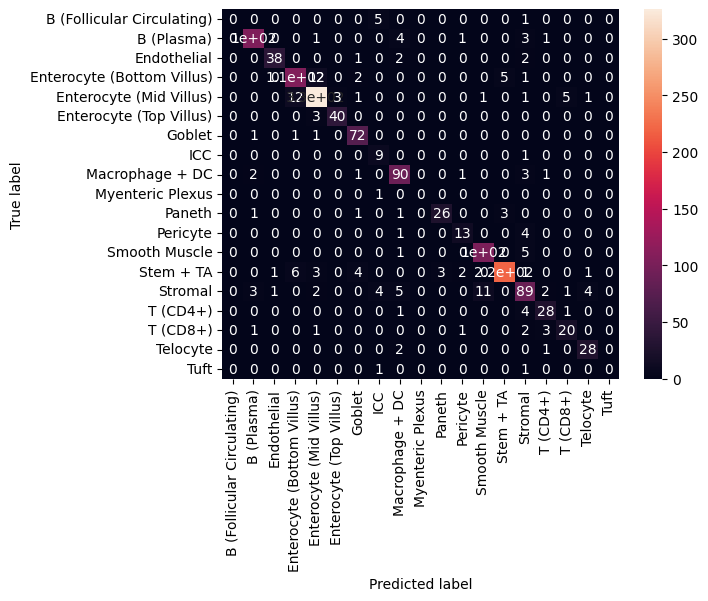

In [11]:
pred_labels = preds.argmax(dim=1)
cf_matrix = confusion_matrix(curr_graph.y[curr_graph.test_mask].detach().cpu(), pred_labels[curr_graph.test_mask].detach().cpu())
sns.heatmap(cf_matrix,
    xticklabels=ordered_names,
    yticklabels=ordered_names,
    annot=True,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Next step: Looking at the predictions that are wrong according to the ground truth but have pretty high confidence on another class.

In [12]:
# Get all the predictions that are wrong and their corresponding features
wrong_mask = (curr_graph.y[curr_graph.test_mask] != pred_labels[curr_graph.test_mask])
wrong_preds = preds[curr_graph.test_mask][wrong_mask]
wrong_features = curr_graph.x[curr_graph.test_mask][wrong_mask]

In [13]:
# Order them by the confidence of a wrong label and make a pandas DataFrame out of it to join it with the initial DataFrame
wrong_features_by_confidence = wrong_features[torch.argsort(wrong_preds.max(dim=1)[0])]
wrong_features_df = pd.DataFrame(wrong_features_by_confidence.detach().cpu().numpy(), dtype=int)

In [14]:
# Join with cells dataset to get the assumed ground truth and cell coordinates
ordered_wrong_features_with_original_cell_id = pd.merge(wrong_features_df, genes.reset_index(), left_on=list(wrong_features_df.columns), right_on=list(genes.columns)).drop(list(wrong_features_df.columns), axis="columns").set_index("cell_id")
ordered_wrong_df = ordered_wrong_features_with_original_cell_id.join(cells)

In [15]:
ordered_wrong_df.to_csv("results/ordered_wrong.csv")